# Item Based CF and Book Recs Demo

This notebook gives functionalities showing top similar books based on IBCF (Item-based Collaborative Filtering).

In [67]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import NearestNeighbors

In [68]:
def make_mean_0(X: sp.sparse.csc_matrix) -> None:
    """
    make columns of a csc_matrix have zero mean
    (this function mutates the underlying data)
    """
    X.data -= get_true_mean(X)

def get_true_mean(X: sp.sparse.csc_matrix) -> None:
    """
    compute mean of each column (over nonzero indices!)
    this won't mutate the underlying X
    a general helper function
    """
    indexer = X.tocoo().col
    v = np.array(X.sum(axis=0)).flatten()
    c = np.array(X.minimum(1).sum(axis=0)).flatten()
    return v[indexer] / np.maximum(c[indexer], 0.5)

In [69]:
def get_top_neigh_dist_ind(
    ratings_train_csc_modified,
    ratings_test_csc_modified,
    n_neighbors=5
):
    knn = NearestNeighbors(metric="cosine")
    knn.fit(ratings_train_csc_modified.transpose())
    neigh_dist, neigh_ind = knn.kneighbors(
        X=ratings_test_csc_modified.transpose(),
        n_neighbors=n_neighbors
    )
    return 1 - neigh_dist, neigh_ind

In [70]:
def update_numer_denom(
    numer_test_csc_ratings,
    denom_test_csc_ratings,
    ratings_test_csc,
    ratings_train_csc,
    ratings_train_mean,
    n_items,
    n_users_test,
    pos # position of which neighbor to update
):
    """
    this function mutates the input csc matrices
    """
    start_ind = 0
    for i in np.arange(n_users_test):
        denom_col = np.zeros(n_items)
        numer_col = np.zeros(n_items)
        baseline_items = ratings_test_csc.indices[
            ratings_test_csc.indptr[i]: ratings_test_csc.indptr[i + 1]
        ]
        n_baseline_items = len(baseline_items)
        end_ind = start_ind + n_baseline_items
        j = neigh_ind[i, pos]
        sim_score = sim_scores[i, pos]
        r_v = ratings_train_csc[:, j]\
                .toarray().flatten()[baseline_items]
        mu_v = ratings_train_mean[j]
        w = sim_score * np.minimum(1, r_v)
        numer_test_csc_ratings.data[start_ind: end_ind] += w * (r_v - mu_v)
        denom_test_csc_ratings.data[start_ind: end_ind] += w
        start_ind = end_ind

In [71]:
def update_prediction(
    ratings_test_csc_predicted,
    ratings_test_mean,
    numer_test_csc_ratings,
    denom_test_csc_ratings
):
    ratings_test_csc_predicted.data =\
        ratings_test_mean[ratings_test_csc_predicted.tocoo().col] +\
        numer_test_csc_ratings.data /\
        np.maximum(
            denom_test_csc_ratings.data,
            10 ** (-30)
        )

In [72]:
def eval_error(ratings_diffs: np.ndarray, sense:str="RMSE"):
    """
    function for evaluating MSE, RMSE, MAE, MAPE of a ratings_diffs array
    """
    if sense not in {"MSE", "RMSE", "MAE", "MAPE"}:
        raise NotImplementedError
    elif sense in {"RMSE", "MAE"}:
        p = {"RMSE": 2, "MAE": 1}[sense]
        return np.linalg.norm(ratings_diffs, p) / ratings_diffs.shape[0] ** (1 / p)
    elif sense == "MSE":
        return ((ratings_diffs)**2).sum()/ratings_diffs.shape[0]
    else:
        return (np.abs(ratings_diffs)/np.abs(ratings_test_csc.data)).sum()/ratings_diffs.shape[0]

## Item-Based Collaborative Filtering with Generated Top 200 Books (Scores + ID)

In [73]:
%%time
results = []
n_neighbors = 201

# transform to csc matrix
csv_dir = "/home/zebalgebra/School/DVA/The-Last-Book-Bender/Data/Raw/"
ratings_all_df = pd.read_csv(
    os.path.join(csv_dir, "ratings.csv")
)
# since we do item-based, book_id and user_id are switched (books are columns)
ratings_all_csc = sp.sparse.csc_matrix(
    (
        ratings_all_df["rating"],
        (
            ratings_all_df["user_id"],
            ratings_all_df["book_id"]
        )
    )
)

# get top recs for books
user_ids = np.arange(10000 + 1)

ratings_train_csc = ratings_all_csc.copy()
ratings_test_csc = ratings_all_csc.copy()
ratings_train_mean = get_true_mean(ratings_train_csc)
ratings_test_mean = get_true_mean(ratings_test_csc)
n_items = ratings_test_csc.shape[0]
n_users_test = 10001

# modify train, test csc matrix
ratings_train_csc_modified = ratings_train_csc.copy().astype(np.float64)
ratings_test_csc_modified = ratings_test_csc.copy().astype(np.float64)
make_mean_0(ratings_train_csc_modified)
make_mean_0(ratings_test_csc_modified)
# get top neighbors and scores
sim_scores, neigh_ind = get_top_neigh_dist_ind(
    ratings_train_csc_modified,
    ratings_test_csc_modified,
    n_neighbors=n_neighbors
)

with open(f'book-top-200.pkl', 'wb') as f:
    pickle.dump([sim_scores, neigh_ind], f)

CPU times: user 7.27 s, sys: 704 ms, total: 7.98 s
Wall time: 8.03 s


In [74]:
print(sim_scores)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.41177088 0.30856051 ... 0.03346572 0.03344025 0.03343182]
 [1.         0.45028636 0.41389503 ... 0.03491968 0.03485617 0.03478531]
 ...
 [1.         0.5199571  0.48985644 ... 0.01554969 0.0155148  0.01551345]
 [1.         0.05358143 0.0497866  ... 0.0136174  0.01361239 0.01356286]
 [1.         0.17128314 0.14358053 ... 0.01995482 0.01995106 0.01990338]]


The similarity scores and top 200 similar books for each books are given stored in `book-top-200.pkl`.

In [75]:
sim_df = pd.DataFrame(
    np.hstack(
        (
            np.arange(1, 10001).reshape((10000, 1)),
            sim_scores[1:, 1:]
        )
    )
)
sim_df.columns = ["book_id", *[f"score of rank {i} similar book" for i in range(1, 201)]]
sim_df["book_id"] = sim_df["book_id"].astype("int")
sim_df

,book_id,score of rank 1 similar book,score of rank 2 similar book,score of rank 3 similar book,score of rank 4 similar book,score of rank 5 similar book,score of rank 6 similar book,score of rank 7 similar book,score of rank 8 similar book,score of rank 9 similar book,...,score of rank 191 similar book,score of rank 192 similar book,score of rank 193 similar book,score of rank 194 similar book,score of rank 195 similar book,score of rank 196 similar book,score of rank 197 similar book,score of rank 198 similar book,score of rank 199 similar book,score of rank 200 similar book
0,1,0.411771,0.308561,0.186353,0.162507,0.157140,0.116227,0.114403,0.113010,0.111709,...,0.034024,0.033875,0.033841,0.033821,0.033560,0.033542,0.033479,0.033466,0.033440,0.033432
1,2,0.450286,0.413895,0.376855,0.328172,0.327037,0.297515,0.157140,0.132038,0.126953,...,0.035368,0.035219,0.035197,0.035189,0.035078,0.034924,0.034922,0.034920,0.034856,0.034785
2,3,0.448119,0.447816,0.400942,0.186353,0.180907,0.168054,0.152496,0.131615,0.130190,...,0.037953,0.037828,0.037706,0.037694,0.037677,0.037676,0.037633,0.037551,0.037289,0.037256
3,4,0.185171,0.170706,0.155655,0.152765,0.147965,0.141324,0.128294,0.123147,0.119817,...,0.033895,0.033795,0.033767,0.033738,0.033617,0.033602,0.033513,0.033502,0.033425,0.033420
4,5,0.218034,0.170706,0.146669,0.142154,0.137420,0.133756,0.126081,0.107386,0.103970,...,0.035466,0.035413,0.035175,0.035144,0.035069,0.035015,0.034874,0.034865,0.034658,0.034602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0.397639,0.225291,0.188271,0.187703,0.167301,0.164037,0.163094,0.161047,0.148262,...,0.023694,0.023630,0.023535,0.023526,0.023482,0.023421,0.023409,0.023176,0.022899,0.022857
9996,9997,0.263339,0.172648,0.073245,0.064155,0.062760,0.060178,0.052366,0.047740,0.047481,...,0.012270,0.012233,0.012231,0.012219,0.012201,0.012136,0.012131,0.012091,0.012073,0.011993
9997,9998,0.519957,0.489856,0.192628,0.079375,0.063140,0.057054,0.054121,0.050907,0.045580,...,0.015779,0.015767,0.015745,0.015720,0.015711,0.015638,0.015625,0.015550,0.015515,0.015513
9998,9999,0.053581,0.049787,0.049492,0.046982,0.045087,0.042286,0.040663,0.040483,0.040085,...,0.013729,0.013705,0.013695,0.013688,0.013654,0.013652,0.013645,0.013617,0.013612,0.013563


In [76]:
rec_df = pd.DataFrame(
    np.hstack(
        (
            np.arange(1, 10001).reshape((10000, 1)),
            neigh_ind[1:, 1:]
        )
    )
)
rec_df.columns = ["book_id", *[f"id of rank {i} similar book" for i in range(1, 201)]]
rec_df

,book_id,id of rank 1 similar book,id of rank 2 similar book,id of rank 3 similar book,id of rank 4 similar book,id of rank 5 similar book,id of rank 6 similar book,id of rank 7 similar book,id of rank 8 similar book,id of rank 9 similar book,...,id of rank 191 similar book,id of rank 192 similar book,id of rank 193 similar book,id of rank 194 similar book,id of rank 195 similar book,id of rank 196 similar book,id of rank 197 similar book,id of rank 198 similar book,id of rank 199 similar book,id of rank 200 similar book
0,1,17,20,3,12,2,9,27,25,23,...,368,389,370,112,992,519,329,417,4603,526
1,2,23,18,24,21,27,25,1,26,37,...,188,56,627,339,1196,83,358,967,58,451
2,3,49,52,56,1,34,73,44,53,51,...,1291,1437,571,1861,85,118,222,541,3083,84
3,4,32,5,15,8,28,58,29,10,14,...,341,227,335,222,741,196,1094,369,740,601
4,5,8,4,28,32,14,29,13,63,58,...,426,413,1,205,317,81,741,646,245,659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,6812,7319,4921,3463,7101,3105,7939,2998,2971,...,1769,4446,891,7818,1594,8058,5722,2706,5904,7596
9996,9997,9004,7264,9666,6131,8034,2950,9751,6298,7245,...,969,501,8433,4515,3529,172,1710,236,7869,1926
9997,9998,8687,7501,3109,7855,5764,7351,9019,9789,9655,...,4464,6982,8358,5665,628,4727,1089,3547,135,687
9998,9999,2742,9542,8073,4956,9375,4309,5761,7518,4389,...,92,30,2132,122,7615,1168,5129,2444,4959,5912


## Looking at Book Infos

Now we look at book infos by joining `books.csv`

In [77]:
# transform to csc matrix
csv_dir = "/home/zebalgebra/School/DVA/The-Last-Book-Bender/Data/Raw/"
books_all_df = pd.read_csv(
    os.path.join(csv_dir, "books_enriched.csv")
)

Say we sample 5 books, and look at the infos.

In [78]:
sample_ids = [2, 6, 9, 42, 420]

In [79]:
books_all_df.columns

Index(['Unnamed: 0', 'index', 'authors', 'average_rating', 'best_book_id',
       'book_id', 'books_count', 'description', 'genres', 'goodreads_book_id',
       'image_url', 'isbn', 'isbn13', 'language_code',
       'original_publication_year', 'original_title', 'pages', 'publishDate',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'ratings_count', 'small_image_url', 'title', 'work_id',
       'work_ratings_count', 'work_text_reviews_count', 'authors_2'],
      dtype='object')

In [114]:
from IPython.display import Image
from IPython.core.display import HTML
def vis_book_by_id(books_all_df, book_id, greeting_str):
    # shows info of entered book
    subset = [
        "title",
        "genres",
        "authors",
        "description",
        "original_publication_year",
        "pages",
        "image_url"
    ]
    book_info = books_all_df[subset].iloc[book_id - 1, :]
    print(greeting_str)
    display(Image(book_info["image_url"]))
    for key in subset:
        print(f"""
        {key}: {book_info[key]}
        """)
def vis_recs(books_all_df, base_book_id, sim_df, rec_df, num_recs):
    # shows info of entered book
    vis_book_by_id(
        books_all_df,
        base_book_id,
        """
        💫 Your entered book ! 😉
        """
    )
    rec_book_ids = rec_df.iloc[base_book_id - 1, 1:num_recs + 1].values
    rec_book_sims = sim_df.iloc[base_book_id - 1, 1:num_recs + 1].values
    for rank, (rec_book_id, rec_book_sim) in enumerate(
        zip(rec_book_ids, rec_book_sims)
    ):
        vis_book_by_id(
            books_all_df,
            rec_book_id,
            f"""
            💫 Rank {rank + 1} similar book of your entered book ! 😱
                (score: {rec_book_sim}, id: {rec_book_id})
            """
        )


        💫 Your entered book ! 😉
        


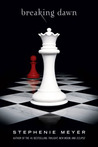


        title: Breaking Dawn (Twilight, #4)
        

        genres: ['young-adult', 'fantasy', 'romance', 'fiction', 'paranormal']
        

        authors: ['Stephenie Meyer']
        

        description: "Don't be afraid," I murmured. "We belong together."I was abruptly overwhelmed by the truth of my own words. This moment was so perfect, so right, there was no way to doubt it.His arms wrapped around me,holding me against him....It felt like every nerve ending in my body was a live wire."Forever," he agreed.WHEN YOU LOVED THE ONE WHO WAS KILLING YOU, IT LEFT YOU NO OPTIONS. How could you run, how could you fight, when doing so would hurt that beloved one? If your life was all you had to give, how could you not give it? If it was someone you truly loved?TO BE IRREVOCABLY IN LOVE WITH A VAMPIRE is both fantasy and nightmare woven into a dangerously heightened reality for Bella Swan. Pulled in one direction by her intense passion for Edward Cullen, and in another by her profound c

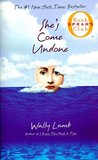


        title: She's Come Undone
        

        genres: ['fiction', 'contemporary', 'chick-lit']
        

        authors: ['Wally Lamb']
        

        description: In this extraordinary coming-of-age odyssey, Wally Lamb invites us to hitch a wild ride on a journey of love, pain, and renewal with the most heartbreakingly comical heroine to come along in years.Meet Dolores Price. She's 13, wise-mouthed but wounded, having bid her childhood goodbye. Stranded in front of her bedroom TV, she spends the next few years nourishing herself with the Mallomars, potato chips, and Pepsi her anxious mother supplies. When she finally orbits into young womanhood at 257 pounds, Dolores is no stronger and life is no kinder. But this time she's determined to rise to the occasion and give herself one more chance before she really goes under.
        

        original_publication_year: 1992.0
        

        pages: 465.0
        

        image_url: https://images.gr-assets.com/books/140831345

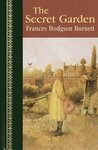


        title: The Secret Garden
        

        genres: ['classics', 'fiction', 'young-adult', 'historical-fiction', 'fantasy']
        

        authors: ['Frances Hodgson Burnett']
        

        description: "One of the most delightful and enduring classics of children's literature, The Secret Garden by Victorian author Frances Hodgson Burnett has remained a firm favorite with children the world over ever since it made its first appearance. Initially published as a serial story in 1910 in The American Magazine, it was brought out in novel form in 1911.  The plot centers round Mary Lennox, a young English girl who returns to England from India, having suffered the immense trauma by losing both her parents in a cholera epidemic. However, her memories of her parents are not pleasant, as they were a selfish, neglectful and pleasure-seeking couple. Mary is given to the care of her uncle Archibald Craven, whom she has never met. She travels to his home, Misselthwaite Manor located 

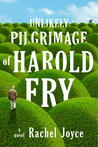


        title: The Unlikely Pilgrimage of Harold Fry (Harold Fry, #1)
        

        genres: ['fiction', 'contemporary', 'travel']
        

        authors: ['Rachel Joyce']
        

        description: Meet Harold Fry, recently retired. He lives in a small English village with his wife, Maureen, who seems irritated by almost everything he does, even down to how he butters his toast. Little differentiates one day from the next. Then one morning the mail arrives, and within the stack of quotidian minutiae is a letter addressed to Harold in a shaky scrawl from a woman he hasn't seen or heard from in twenty years. Queenie Hennessy is in hospice and is writing to say goodbye. Harold pens a quick reply and, leaving Maureen to her chores, heads to the corner mailbox. But then, as happens in the very best works of fiction, Harold has a chance encounter, one that convinces him that he absolutely must deliver his message to Queenie in person. And thus begins the unlikely pilgrimage. Haro

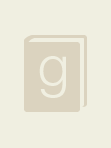


        title: The Memory Keeper's Daughter
        

        genres: ['fiction', 'contemporary', 'historical-fiction', 'chick-lit']
        

        authors: ['Kim Edwards']
        

        description: On a winter night in 1964, Dr. David Henry is forced by a blizzard to deliver his own twins. His son, born first, is perfectly healthy. Yet when his daughter is born, he sees immediately that she has Down's Syndrome. Rationalizing it as a need to protect Norah, his wife, he makes a split-second decision that will alter all of their lives forever. He asks his nurse to take the baby away to an institution and never to reveal the secret. But Caroline, the nurse, cannot leave the infant. Instead, she disappears into another city to raise the child herself. So begins this story that unfolds over a quarter of a century - in which these two families, ignorant of each other, are yet bound by the fateful decision made that long-ago winter night. Norah Henry, who knows only that her daughter

In [119]:
vis_recs(books_all_df, 50, sim_df, rec_df, 4)